In [1]:
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook 
from sklearn import preprocessing, decomposition
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
import math

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
train = pd.read_csv('/data/spooky_author/train.csv')
test = pd.read_csv('/data/spooky_author/test.csv')

In [4]:
train_svec = pd.read_csv("/data/spooky_author/train_sen2vec.dat", header=None, delimiter=r"\s+")
test_svec = pd.read_csv("/data/spooky_author/test_sen2vec.dat", header=None, delimiter=r"\s+")

In [5]:
train_svec.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.053488,0.067535,-0.019853,0.068202,-0.162330,0.065901,0.028737,0.166400,0.046524,-0.003078,...,0.049284,0.161730,-0.058413,-0.160580,0.127950,-0.19166,-0.009965,0.063620,0.017981,0.129180
1,-0.037915,-0.120860,-0.072031,0.270100,0.313400,-0.424230,0.159270,-0.081277,0.067744,-0.301060,...,-0.085751,-0.101140,0.359500,-0.131190,0.212910,0.12213,0.015365,-0.041215,-0.073558,0.314440
2,0.075236,0.048786,0.028489,-0.094034,0.074649,-0.192110,0.106330,-0.044206,0.057636,-0.071370,...,0.094568,0.007301,0.140590,0.052424,0.035876,-0.14266,-0.271390,-0.150620,-0.070459,0.028201
3,-0.102540,-0.024934,0.160980,-0.037602,-0.078291,-0.096557,0.033061,0.054484,-0.273560,0.110370,...,-0.093459,-0.080855,-0.199820,0.114150,-0.072864,0.04788,-0.140480,-0.043337,-0.100850,0.149470
4,0.130780,0.033440,-0.144580,-0.025771,-0.307520,-0.092067,-0.014837,0.030967,-0.057631,0.088422,...,-0.091501,0.167880,0.119080,-0.161370,-0.245880,-0.12596,-0.031658,0.031667,0.027196,0.213870


In [6]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [8]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(multiclass_logloss_foreach(actual,predicted))
    return vsota / rows

def multiclass_logloss_foreach(actual,predicted,eps=1e-15):
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    return np.sum(-1.0 * actual * np.log(clip), axis=1)
    

def accuracy(actual,predicted):
    if len(actual.shape) != 1:
        actual = np.argmax(actual, axis=1)
        
    return np.sum(actual == np.argmax(predicted, axis=1))/actual.shape[0]

def print_metrics(actual, predicted):
    print ("logloss: %0.3f, accuracy: %0.3f " % (multiclass_logloss(actual, predicted), accuracy(actual, predicted)))

In [9]:
lbl_enc = preprocessing.LabelEncoder()
labels = lbl_enc.fit_transform(train.author.values)

In [10]:
xtrain, xvalid, ytrain, yvalid, xvtrain, xvvalid = train_test_split(train.text.values, labels, train_svec.as_matrix(),
                                                  stratify=labels, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

xtest = test.text.values
xvtest = test_svec.as_matrix()

In [11]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

In [12]:
cwtv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
cwtv.fit(list(xtrain) + list(xvalid))
xtrain_cwtv =  cwtv.transform(xtrain) 
xvalid_cwtv = cwtv.transform(xvalid)
xtest_cwtv = cwtv.transform(xtest)

In [13]:
cctv = CountVectorizer(analyzer='char_wb',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
cctv.fit(list(xtrain) + list(xvalid))
xtrain_cctv =  cctv.transform(xtrain) 
xvalid_cctv = cctv.transform(xvalid)
xtest_cctv = cctv.transform(xtest)

In [14]:
xtrain_cctv.shape

(17621, 9236)

In [15]:
np.array(xtrain_cctv)

array(<17621x9236 sparse matrix of type '<class 'numpy.int64'>'
	with 3762200 stored elements in Compressed Sparse Row format>, dtype=object)

In [16]:
xtrain_cwtv_cctv = hstack((xtrain_tfv, xtrain_cwtv,xtrain_cctv))
xvalid_cwtv_cctv = hstack((xvalid_tfv, xvalid_cwtv,xvalid_cctv))
xtest_cwtv_cctv = hstack((xtest_tfv, xtest_cwtv,xtest_cctv))

In [17]:
xvalid_cwtv_cctv.shape

(1958, 424604)

In [18]:
comb_lf = LogisticRegression(C=1.0)
comb_lf.fit(xtrain_cwtv_cctv, ytrain)
predictions_comb = comb_lf.predict_proba(xvalid_cwtv_cctv)

print_metrics(yvalid, predictions_comb)

logloss: 0.495, accuracy: 0.818 


In [19]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB(alpha=0.1)
clf.fit(xtrain_tfv, ytrain)
predictions_nbtfidf = clf.predict_proba(xvalid_tfv)

print_metrics(yvalid, predictions_nbtfidf)

logloss: 0.440, accuracy: 0.826 


In [20]:
predictions_ensamble1 = (predictions_comb + predictions_nbtfidf)/2

print_metrics(yvalid, predictions_ensamble1)

logloss: 0.392, accuracy: 0.854 


# Submit first model

In [21]:
test_predictions_comb = comb_lf.predict_proba(xtest_cwtv_cctv)
test_predictions_nbtfidf = clf.predict_proba(xtest_tfv)
test_predictions_ensamble1 = (predictions_comb + predictions_nbtfidf)/2

In [ ]:
test_result = pd.concat([test['id'],pd.DataFrame(test_predictions_ensamble1, columns=lbl_enc.classes_)], axis=1)

In [ ]:
test_result.to_csv('/data/spooky_author/submition_1.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

# Failure cases

In [22]:
losses = multiclass_logloss_foreach(yvalid, predictions_ensamble1)
sorted_by_loss = np.argsort(losses)

In [23]:
author_classes = lbl_enc.classes_

for i in range(3):
    idx = sorted_by_loss[-(i+1)]
    
    print("%d Actual: %s, Predicted: %s, loss: %0.3f " % (
        idx,
        author_classes[yvalid[idx]],
        author_classes[np.argmax(predictions_ensamble1[idx])],
        losses[idx]
    ))
    
    print(xvalid[idx])
    print('')

154 Actual: MWS, Predicted: EAP, loss: 5.201 
The Cenci The Brides' Tragedy, by T. L. Beddoes, Esq.

1138 Actual: HPL, Predicted: EAP, loss: 5.020 
I repeat to you, gentlemen, that your inquisition is fruitless.

503 Actual: MWS, Predicted: HPL, loss: 3.953 
The windows of the room had before been darkened, and I felt a kind of panic on seeing the pale yellow light of the moon illuminate the chamber.



# Word vectors

In [24]:
embeddings_index = {}
f = open('/data/glove/glove.840B.300d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = ' '.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
        
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2195895 word vectors.


In [25]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [26]:
xtrain_glove = np.array([sent2vec(x) for x in tqdm(xtrain)])
xvalid_glove = np.array([sent2vec(x) for x in tqdm(xvalid)])
xtest_glove = np.array([sent2vec(x) for x in tqdm(xtest)])

100%|██████████| 8392/8392 [00:02<00:00, 3524.15it/s]


In [27]:
glove_lr = LogisticRegression(C=1.0)
glove_lr.fit(xtrain_glove, ytrain)
predictions_glove = glove_lr.predict_proba(xvalid_glove)

print_metrics(yvalid, predictions_glove)

logloss: 0.732, accuracy: 0.715 


In [28]:
xtrain_cwtv_cctv_glove = hstack((xtrain_glove,xtrain_cwtv,xtrain_cctv))
xvalid_cwtv_cctv_glove = hstack((xvalid_glove,xvalid_cwtv,xvalid_cctv))
xtest_cwtv_cctv_glove = hstack((xtest_glove,xtest_cwtv,xtest_cctv))

In [29]:
multi_lr_2 = LogisticRegression(C=1.0)
multi_lr_2.fit(xtrain_cwtv_cctv_glove, ytrain)
predictions_multi_2 = multi_lr_2.predict_proba(xvalid_cwtv_cctv_glove)

print_metrics(yvalid, predictions_multi_2)

logloss: 0.480, accuracy: 0.829 


In [30]:
predictions_ensamble2 = (predictions_multi_2 + predictions_nbtfidf)/2

print_metrics(yvalid, predictions_ensamble2)

logloss: 0.387, accuracy: 0.863 


# Submit second model 

In [31]:
test_predictions_multi2 = multi_lr_2.predict_proba(xtest_cwtv_cctv_glove)
test_predictions_ensamble2 = (test_predictions_multi2 + test_predictions_nbtfidf)/2

In [ ]:
test_result_2 = pd.concat([test['id'],pd.DataFrame(test_predictions_ensamble2, columns=lbl_enc.classes_)], axis=1)
test_result_2.to_csv('/data/spooky_author/submition_2.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

# Neural network on existing features

In [32]:
print(xtrain_cwtv_cctv_glove.shape, ytrain.shape)

(17621, 409802) (17621,)


In [33]:
from keras import backend as K

Using TensorFlow backend.


In [34]:
K.clear_session()

In [35]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout
from keras.optimizers import Nadam

dl_model_1 = Sequential([
    Dense(100, input_shape=(xvalid_cwtv_cctv_glove.shape[1],)),
    LeakyReLU(alpha=0.3),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

opt = Nadam()
dl_model_1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [36]:
dl_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               40980300  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 40,980,603
Trainable params: 40,980,603
Non-trainable params: 0
_________________________________________________________________


In [37]:
def batches_from_sparse_array(x,y, batch_size=64):
    xcsr = x.tocsr()
    while True:
        for i in range(0, x.shape[0], batch_size):
            yield (xcsr[i:i+batch_size].todense(), y[i:i+batch_size])
        

In [38]:
batch_size = 256

train_gen = batches_from_sparse_array(xtrain_cwtv_cctv_glove, ytrain, batch_size=batch_size)
valid_gen = batches_from_sparse_array(xvalid_cwtv_cctv_glove, yvalid, batch_size=batch_size)

steps = math.ceil(ytrain.shape[0]/batch_size)
valid_steps = math.ceil(yvalid.shape[0]/batch_size)

dl_model_1.fit_generator(
    train_gen, 
    steps_per_epoch=steps,
    validation_data=valid_gen,
    validation_steps = valid_steps,
    epochs=1
)

Epoch 1/1
69/69 [==============================] - 38s 550ms/step - loss: 0.8187 - acc: 0.6847 - val_loss: 0.4626 - val_acc: 0.8192


In [39]:
valid_gen = batches_from_sparse_array(xvalid_cwtv_cctv_glove, yvalid, batch_size=batch_size)
steps = math.ceil(xvalid_cwtv_cctv_glove.shape[0]/batch_size)
valid_predictions_dl_1 = dl_model_1.predict_generator(valid_gen, steps=steps)

print_metrics(yvalid, valid_predictions_dl_1)

logloss: 0.463, accuracy: 0.819 


In [40]:
best_loss = 100
best_params = (0,0,0,0)
for i in tqdm(np.arange(0,1,0.02)):
    for j in np.arange(0,1-i,0.02):
        for k in np.arange(0,1-i-j,0.02):
            predictions_ensamble2 = (
                i*valid_predictions_dl_1 + 
                j*predictions_multi_2 + 
                k*predictions_comb + 
                (1-i-j-k)*predictions_nbtfidf
            )
            
            loss = multiclass_logloss(yvalid, predictions_ensamble2)
            if best_loss > loss: 
                best_loss = loss
                best_params = (i,j,k,1-i-j-k)

print(best_params)
predictions_ensamble2 = (
                best_params[0]*valid_predictions_dl_1 + 
                best_params[1]*predictions_multi_2 + 
                best_params[2]*predictions_comb + 
                best_params[3]*predictions_nbtfidf
            )

print_metrics(yvalid, predictions_ensamble2)

100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

(0.0, 0.54000000000000004, 0.0, 0.45999999999999996)
logloss: 0.386, accuracy: 0.859 


# Submit third model

In [41]:
test_gen = batches_from_sparse_array(xtest_cwtv_cctv_glove, np.zeros(xtest_cwtv_cctv_glove.shape[0]), batch_size=batch_size)
steps = math.ceil(xtest_cwtv_cctv_glove.shape[0]/batch_size)
test_predictions_dl_1 = dl_model_1.predict_generator(test_gen, steps=steps)

In [42]:
test_predictions_ensamble2 = (
                best_params[0]*test_predictions_dl_1 + 
                best_params[1]*test_predictions_multi2 + 
                best_params[2]*test_predictions_comb + 
                best_params[3]*test_predictions_nbtfidf
            )

In [ ]:
test_result_3 = pd.concat([test['id'],pd.DataFrame(test_predictions_ensamble2, columns=lbl_enc.classes_)], axis=1)
test_result_3.to_csv('/data/spooky_author/submition_3.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

# Sentence to vector model

In [43]:
sen2vec_lr = LogisticRegression(C=1.0)
sen2vec_lr.fit(xvtrain, ytrain)
predictions_sen2vec = sen2vec_lr.predict_proba(xvvalid)

print_metrics(yvalid, predictions_sen2vec)

logloss: 0.778, accuracy: 0.683 


In [44]:
xtrain_cwtv_cctv_s2v_glove = hstack((xtrain_glove,xvtrain,xtrain_cwtv,xtrain_cctv))
xvalid_cwtv_cctv_s2v_glove = hstack((xvalid_glove,xvvalid,xvalid_cwtv,xvalid_cctv))
xtest_cwtv_cctv_s2v_glove = hstack((xtest_glove,xvtest,xtest_cwtv,xtest_cctv))

In [45]:
multi_lr_3 = LogisticRegression(C=1.0)
multi_lr_3.fit(xtrain_cwtv_cctv_s2v_glove, ytrain)
predictions_multi_3 = multi_lr_3.predict_proba(xvalid_cwtv_cctv_s2v_glove)

print_metrics(yvalid, predictions_multi_3)

logloss: 0.497, accuracy: 0.824 


In [46]:
best_loss = 100
best_params = (0,0,0,0)
step = 0.05
for i in np.arange(0,0.1,step):
    for j in np.arange(0,1-i,step):
        for k in np.arange(0,1-i-j,step):
            for l in np.arange(0,1-i-j-k, step):
                predictions_ensamble3 = (
                    i*valid_predictions_dl_1 + 
                    j*predictions_multi_2 + 
                    k*predictions_comb + 
                    l*predictions_nbtfidf + 
                    (1-i-j-k-l)*predictions_multi_3
                )

                loss = multiclass_logloss(yvalid, predictions_ensamble3)
                if best_loss > loss: 
                    best_loss = loss
                    best_params = (i,j,k,l,1-i-j-k-l)

print(best_params)
predictions_ensamble3 = (
                best_params[0]*valid_predictions_dl_1 + 
                best_params[1]*predictions_multi_2 + 
                best_params[2]*predictions_comb + 
                best_params[3]*predictions_nbtfidf +
                best_params[4]*predictions_multi_3
            )

print_metrics(yvalid, predictions_ensamble3)

(0.0, 0.30000000000000004, 0.0, 0.45000000000000001, 0.24999999999999994)
logloss: 0.385, accuracy: 0.858 


# Submit fourth model 

In [47]:
test_predictions_multi_3 = multi_lr_3.predict_proba(xtest_cwtv_cctv_s2v_glove)

In [48]:
test_predictions_ensamble3 = (
                best_params[0]*test_predictions_dl_1 + 
                best_params[1]*test_predictions_multi2 + 
                best_params[2]*test_predictions_comb + 
                best_params[3]*test_predictions_nbtfidf + 
                best_params[4]*test_predictions_multi_3
            )

In [65]:
test_result_4 = pd.concat([test['id'],pd.DataFrame(test_predictions_ensamble3, columns=lbl_enc.classes_)], axis=1)
test_result_4.to_csv('/data/spooky_author/submition_4.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

# Examine model

In [49]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [50]:
%matplotlib inline

In [51]:
pyvalid = np.argmax(predictions_ensamble2, axis=1)

In [52]:
confusion_matrix(yvalid,pyvalid)

array([[696,  30,  64],
       [ 57, 474,  33],
       [ 68,  25, 511]])

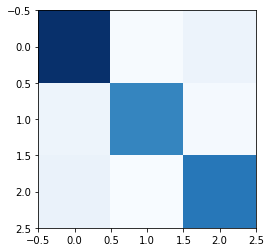

In [53]:
plt.imshow(confusion_matrix(yvalid,pyvalid), cmap=plt.cm.Blues)

In [54]:
line_lens = list(map(lambda x: len(x),xvalid))

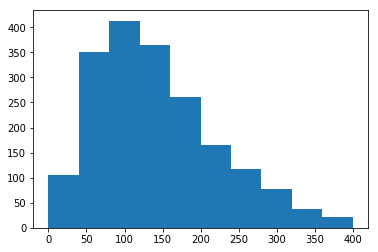

In [55]:
d = plt.hist(line_lens, bins=10, range=(0, 400))

In [59]:
def print_metrics_for_len_groups(preds,keys = [30,50,100,150,200,250,300,301]):
    

    ygrouped = {k:[] for k in keys}
    pred_grouped = {k:[] for k in keys}

    def get_bin(v):
        for i in keys:
            if i > v:
                return i
        return keys[-1]

    for i in range(len(yvalid)):
        b = get_bin(line_lens[i])
        ygrouped[b].append(yvalid[i])
        pred_grouped[b].append(preds[i])

    for k in keys:
        print('Less than', k, 'characters', end=' > ')
        print_metrics(np.array(ygrouped[k]),np.array(pred_grouped[k]))

In [60]:
print_metrics_for_len_groups(predictions_ensamble2)

Less than 30 characters > logloss: 0.666, accuracy: 0.739 
Less than 50 characters > logloss: 0.594, accuracy: 0.783 
Less than 100 characters > logloss: 0.522, accuracy: 0.797 
Less than 150 characters > logloss: 0.401, accuracy: 0.857 
Less than 200 characters > logloss: 0.258, accuracy: 0.926 
Less than 250 characters > logloss: 0.297, accuracy: 0.891 
Less than 300 characters > logloss: 0.209, accuracy: 0.926 
Less than 301 characters > logloss: 0.178, accuracy: 0.915 


In [62]:
print_metrics_for_len_groups(predictions_ensamble2, [150,151])

Less than 150 characters > logloss: 0.485, accuracy: 0.818 
Less than 151 characters > logloss: 0.247, accuracy: 0.915 


# tfidf weighted glove vectors

In [63]:
# Always start with these features. They work (almost) everytime!
tfvs = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1,1), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfvs.fit(list(xtrain) + list(xvalid))
xtrain_tfvs =  tfvs.transform(xtrain) 
xvalid_tfvs = tfvs.transform(xvalid)
xtest_tfvs = tfvs.transform(xtest)

In [64]:
tfvs_vocab = tfvs.vocabulary_

In [65]:
len(tfvs.stop_words_)

13003

In [66]:
def sent2vec_tfidf(s,tfidf):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        if w in tfvs_vocab:
            weight = tfidf[0,tfvs_vocab[w]]
        else:
            weight = 0.01
        try:
            M.append(embeddings_index[w]*weight)
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    l = np.sqrt((v ** 2).sum())
    
    if type(v) != np.ndarray or l < 0.0000001:
        return np.zeros(300)
    return v / l

In [67]:
xtrain_weighted_glove = np.array([sent2vec_tfidf(x,xtrain_tfvs[i]) for i,x in enumerate(xtrain)])
xvalid_weighted_glove = np.array([sent2vec_tfidf(x,xvalid_tfvs[i]) for i,x in enumerate(xvalid)])
xtest_weighted_glove = np.array([sent2vec_tfidf(x,xtest_tfvs[i]) for i,x in enumerate(xtest)])

In [68]:
wglove_lr = LogisticRegression(C=1.0)
wglove_lr.fit(xtrain_weighted_glove, ytrain)
predictions_wglove = wglove_lr.predict_proba(xvalid_weighted_glove)

print_metrics(yvalid, predictions_wglove)

logloss: 0.760, accuracy: 0.682 


In [69]:
xtrain_cwtv_cctv_s2v_wglove = hstack((xtrain_weighted_glove,xtrain_glove,xvtrain,xtrain_cwtv,xtrain_cctv))
xvalid_cwtv_cctv_s2v_wglove = hstack((xvalid_weighted_glove,xvalid_glove,xvvalid,xvalid_cwtv,xvalid_cctv))
xtest_cwtv_cctv_s2v_wglove = hstack((xtest_weighted_glove,xtest_glove,xvtest,xtest_cwtv,xtest_cctv))

In [70]:
multi_lr_4 = LogisticRegression(C=1.0)
multi_lr_4.fit(xtrain_cwtv_cctv_s2v_wglove, ytrain)
predictions_multi_4 = multi_lr_4.predict_proba(xvalid_cwtv_cctv_s2v_wglove)

print_metrics(yvalid, predictions_multi_4)

logloss: 0.491, accuracy: 0.826 


In [77]:
best_loss = 100
best_params = (0,0,0,0)
step = 0.1
for i in np.arange(0,1,step):
    for j in np.arange(0,1-i,step):
        for k in np.arange(0,1-i-j,step):
            for l in np.arange(0,1-i-j-k, step):
                for m in np.arange(0,1-i-j-k-l, step):
                    predictions_ensamble3 = (
                        i*valid_predictions_dl_1 + 
                        j*predictions_multi_2 + 
                        k*predictions_comb + 
                        l*predictions_nbtfidf + 
                        m*predictions_multi_3 + 
                        (1-i-j-k-l-m)*predictions_multi_4
                    )

                    loss = multiclass_logloss(yvalid, predictions_ensamble3)
                    if best_loss > loss: 
                        best_loss = loss
                        best_params = (i,j,k,l,m,1-i-j-k-l-m)

print(best_params)
predictions_ensamble4 = (
                best_params[0]*valid_predictions_dl_1 + 
                best_params[1]*predictions_multi_2 + 
                best_params[2]*predictions_comb + 
                best_params[3]*predictions_nbtfidf +
                best_params[4]*predictions_multi_3 +
                best_params[5]*predictions_multi_4
            )

print_metrics(yvalid, predictions_ensamble4)

(0.0, 0.30000000000000004, 0.0, 0.40000000000000002, 0.0, 0.29999999999999993)
logloss: 0.384, accuracy: 0.854 


# Submit fifth model

In [78]:
test_predictions_multi_4 = multi_lr_4.predict_proba(xtest_cwtv_cctv_s2v_wglove)

In [79]:
test_predictions_ensamble4 = (
                best_params[0]*test_predictions_dl_1 + 
                best_params[1]*test_predictions_multi2 + 
                best_params[2]*test_predictions_comb + 
                best_params[3]*test_predictions_nbtfidf + 
                best_params[4]*test_predictions_multi_3 + 
                best_params[5]*test_predictions_multi_4
            )

In [80]:
test_result_5 = pd.concat([test['id'],pd.DataFrame(test_predictions_ensamble4, columns=lbl_enc.classes_)], axis=1)
test_result_5.to_csv('/data/spooky_author/submition_5.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

# Copy good idea from kaggle
https://www.kaggle.com/marcospinaci/0-335-log-loss-in-a-dozen-lines/code

In [76]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

models = [('MultiNB', MultinomialNB(alpha=0.03)),
          ('Calibrated MultiNB', CalibratedClassifierCV(
              MultinomialNB(alpha=0.03), method='isotonic')),
          ('Calibrated BernoulliNB', CalibratedClassifierCV(
              BernoulliNB(alpha=0.03), method='isotonic')),
          ('Calibrated Huber', CalibratedClassifierCV(
              SGDClassifier(loss='modified_huber', alpha=1e-4,
                            max_iter=10000, tol=1e-4), method='sigmoid')),
          ('Logit', LogisticRegression(C=30))]


vectorizer=TfidfVectorizer(token_pattern=r'\w{1,}', sublinear_tf=True, ngram_range=(1,2))
clf = VotingClassifier(models, voting='soft', weights=[3,3,3,1,1])

vectorizer.fit(list(xtrain) + list(xvalid))

xtrain_tfv2 = vectorizer.transform(xtrain)
xvalid_tfv2 = vectorizer.transform(xvalid)
xtest_tfv2 = vectorizer.transform(xtest)


clf.fit(xtrain_tfv2, ytrain)
predictions_tfv2 = clf.predict_proba(xvalid_tfv2)

print_metrics(yvalid, predictions_tfv2)

logloss: 0.354, accuracy: 0.868 


In [94]:
best_loss = 100
best_params = (0,0,0,0,0)
step = 0.1
for i in np.arange(0,1+step,step):
    for j in np.arange(0,1-i+step,step):
        for k in np.arange(0,1-i-j+step,step):
            for l in np.arange(0,1-i-j-k+step, step):
                predictions_ensamble5 = (
                    i*predictions_multi_2 + 
                    j*predictions_nbtfidf + 
                    k*predictions_multi_3 + 
                    l*predictions_tfv2 +
                    (1-i-j-k-l)*predictions_multi_4
                )

                loss = multiclass_logloss(yvalid, predictions_ensamble5)
                if best_loss > loss: 
                    best_loss = loss
                    best_params = (i,j,k,l,1-i-j-k-l)

print(best_params)
predictions_ensamble5 = (
                best_params[0]*predictions_multi_2 + 
                best_params[1]*predictions_nbtfidf +
                best_params[2]*predictions_multi_3 +
                best_params[3]*predictions_tfv2 +
                best_params[4]*predictions_multi_4
            )

print_metrics(yvalid, predictions_ensamble5)

(0.0, 0.0, 0.0, 0.80000000000000004, 0.19999999999999996)
logloss: 0.347, accuracy: 0.878 


# Submit sixth model

In [95]:
test_predictions_tfv2 = clf.predict_proba(xtest_tfv2)

In [97]:
test_predictions_ensamble5 = (
                best_params[0]*test_predictions_multi2 + 
                best_params[1]*test_predictions_nbtfidf +
                best_params[2]*test_predictions_multi_3 +
                best_params[3]*test_predictions_tfv2 +
                best_params[4]*test_predictions_multi_4
            )

In [98]:
test_result_6 = pd.concat([test['id'],pd.DataFrame(test_predictions_ensamble5, columns=lbl_enc.classes_)], axis=1)
test_result_6.to_csv('/data/spooky_author/submition_6.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

# Ideas

- boost ensamble
- attention model
- conv network